In [1]:
import pandas as pd
import os
from PIL import Image
import numpy as np
from numpy import save, load
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, \
    GlobalMaxPool2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, Lambda
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras import backend as K


from tqdm import tqdm
from collections import Counter

Using TensorFlow backend.


In [2]:
def read_and_resize(filepath, input_shape=(256, 256)):
    im = Image.open((filepath)).convert('RGB')
    im = im.resize(input_shape)
    im_array = np.array(im, dtype="uint8")#[..., ::-1]
    return np.array(im_array / (np.max(im_array)+ 0.001), dtype="float32")

In [3]:
datagen = ImageDataGenerator(
    rotation_range=6,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1)

In [4]:
def augment(im_array):
    im_array = datagen.random_transform(im_array)
    return im_array

In [1]:
def gen(df, batch_size=16, aug=False):
    df = df.sample(frac=1)

    dict_age = {'(0, 2)' : 0,
                '(4, 6)' : 1,
                '(8, 12)' : 2,
                '(15, 20)' : 3,
                '(25, 32)' : 4,
                '(38, 43)' : 5,
                '(48, 53)' : 6,
                '(60, 100)' : 7}

    while True:
        for i, batch in enumerate([df[i:i+batch_size] for i in range(0,df.shape[0],batch_size)]):
            if aug:
                images = np.array([augment(read_and_resize(file_path)) for file_path in batch.path.values])
            else:
                images = np.array([read_and_resize(file_path) for file_path in batch.path.values])


            labels = np.array([dict_age[g] for g in batch.age.values])
            labels = labels[..., np.newaxis]

            yield images, labels

In [2]:
def get_model(n_classes=1):

    base_model = ResNet50(weights="./resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5", include_top=False)

    #for layer in base_model.layers:
    #    layer.trainable = False

    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.5)(x)
    if n_classes == 1:
        x = Dense(n_classes, activation="sigmoid")(x)
    else:
        x = Dense(n_classes, activation="softmax")(x)

    base_model = Model(base_model.input, x, name="base_model")
    if n_classes == 1:
        base_model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer="adam")
    else:
        base_model.compile(loss="sparse_categorical_crossentropy", metrics=['acc'], optimizer="adam")

    return base_model

In [3]:
 if __name__ == "__main__":
    base_path = "./Dataset-copy/"

    dict_age = {'(0, 2)' : 0,
                '(4, 6)' : 1,
                '(8, 12)' : 2,
                '(15, 20)' : 3,
                '(25, 32)' : 4,
                '(38, 43)' : 5,
                '(48, 53)' : 6,
                '(60, 100)' : 7}

    bag = 3

    all_indexes = list(range(5))

    accuracies = []
    print("Reading train and test CSV files ")
    train_df = pd.read_csv("train_faces_concactenated_data_with_path_with_age_range.csv")
    test_df = pd.read_csv("test_faces_concactenated_data_with_path_with_age_range.csv")
    print("Reading Done.")
    cnt_ave = 0
    predictions = 0
    print("Extracting test labels and test images from files")
    test_images = load("test_images_np.npy")
    test_labels = load("test_labels_np.npy")
    print("Extracting Done.")
    tr_tr, tr_val = train_test_split(train_df, test_size=0.1,random_state = 100)
    file_path = "baseline_age.h5"
    
    print("Generating callback_list")
    
    checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

    early = EarlyStopping(monitor="val_acc", mode="max", patience=10)

    reduce_on_plateau = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.1, patience=5)

    callbacks_list = [checkpoint, early, reduce_on_plateau]  # early
    print("Done Generating callbacklist.")
    print("generating Model")
    model = get_model(n_classes=len(dict_age))
    print("Done generating model")
    print("Running Fit_generator")
    model.fit_generator(gen(tr_tr, aug=True), 
                        validation_data=gen(tr_val), 
                        epochs=200, 
                        verbose=1, 
                        workers=1,
                        callbacks=callbacks_list,
                        steps_per_epoch=1700, 
                        validation_steps=30,
                        use_multiprocessing=False)
    model.save(file_path)
    print("Trained Model saved to disk")

Reading train and test CSV files 


NameError: name 'pd' is not defined

In [8]:
model = load_model("baseline_age.h5")

In [9]:
y_predict = model.predict(test_images)

In [24]:
dict_age = {'(0, 2)' : 0,
                '(4, 6)' : 1,
                '(8, 12)' : 2,
                '(15, 20)' : 3,
                '(25, 32)' : 4,
                '(38, 43)' : 5,
                '(48, 53)' : 6,
                '(60, 100)' : 7}
dict_val_to_age = {0:'(0, 2)',1:'(4, 6)',2:'(8, 12)',3:'(15, 20)',4:'(25, 32)',5:'(38, 43)',6:'(48, 53)',7:'(60, 100)'}
index = 123
image_pred = y_predict[index]
class_pred = max(list(image_pred))
class_val = list(image_pred).index(class_pred)
class_number = dict_val_to_age[int(class_val)]
print(class_number)

(25, 32)


(4, 6)


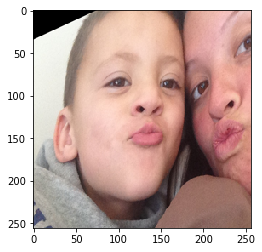

In [25]:
import matplotlib.pyplot as plt
plt.imshow(test_images[index])
print(dict_val_to_age[test_labels[index]])

In [73]:
import numpy as np
y = np.array(y_predict)
y = np.unique(y)

array([0.044061  , 0.04502423, 0.0513963 , 0.05309394, 0.09795763,
       0.1039804 , 0.11203967, 0.11407509, 0.12966135, 0.1299688 ,
       0.13005386, 0.13913581, 0.14203358, 0.14477992, 0.27539802,
       0.28734037], dtype=float32)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [78]:
len(y_predict)

3676

In [8]:
test_df = pd.read_csv("test_faces_concactenated_data_with_path_with_age_range.csv")
test_images = np.array([read_and_resize(file_path) for file_path in test_df.path.values])

In [15]:
dict_age = {'(0, 2)' : 0,
                '(4, 6)' : 1,
                '(8, 12)' : 2,
                '(15, 20)' : 3,
                '(25, 32)' : 4,
                '(38, 43)' : 5,
                '(48, 53)' : 6,
                '(60, 100)' : 7}

test_labels = np.array([dict_age[a] for a in test_df.age.values])

In [10]:
from numpy import save, load

In [14]:
save("test_images_np.npy",test_images)

In [17]:
save("test_labels_np.npy",test_labels)